## Imports

In [1]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Load data (of a single time slice)

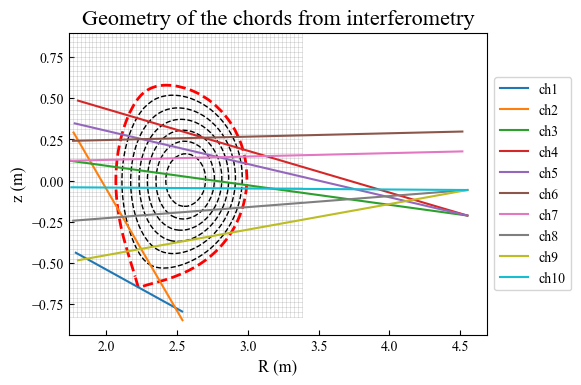

In [2]:
shot = 53259 # Shot number
t = 5.21    # Time (relative to the start of plasma)

# Geometry of the chords from interferometer (lines of sight)
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

# Magnetic equilibrium calculated by equilibrium code NICE
equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

# Line integrated electron density measured by interferometer
interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

# Density profile calculated by equilibrium code NICE, to be used to generate synthetic data
dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

## Validation of the forward model

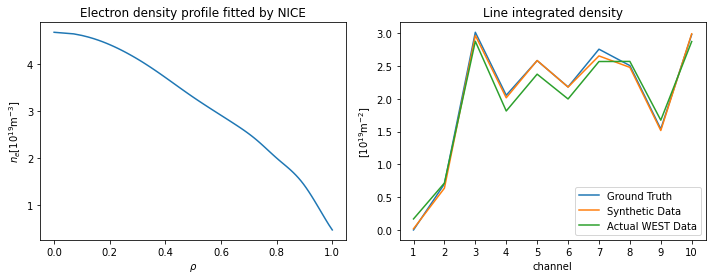

In [9]:
EXP_ER = 0.03 #background noise order of magnitude
    
def data_gen(prof_1d, R):
    lid_true = R @ prof_1d
    lid_data = lid_true + np.random.normal(loc=0, scale=EXP_ER, size=len(lid_true))
    return lid_true, lid_data

                                           
# The response matrix used for calculating line integrals
R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)

lid_true, lid_data = data_gen(dens_prof.dens_1d,R)                                           

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(dens_prof.rho_tor_norm_1d, dens_prof.dens_1d)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$n_e[\mathrm{10^{19} m^{-3}}]$')
ax1.set_title('Electron density profile fitted by NICE')

ax2.plot(interf.channels.compressed(), lid_true, label='Ground Truth')
ax2.plot(interf.channels.compressed(), lid_data, label='Synthetic Data')
ax2.plot(interf.channels.compressed(), interf.lid.compressed(), label='Actual WEST Data')

ax2.set_xticks(interf.channels.data)
ax2.set_xlabel('channel')
ax2.set_ylabel(r'$[\mathrm{10^{19} m^{-2}}]$')
ax2.set_title('Line integrated density')
ax2.legend()
plt.tight_layout()



Not good if zero, as need to be chol_inverted.
The Determinent of K is: 0.0
The Determinent of cov_li is: 2.43e-08
The Determinent of cov_post3 is: 0.0


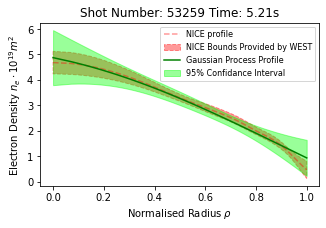

In [10]:
lid_d = lid_data
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))
##Prior
rho_1d = dens_prof.rho_tor_norm_1d
N = len(rho_1d)
mu_prior = np.zeros(N)
#exponential square kernel
def Kernel(rho1,rho2,params):
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    return amp**2 * np.exp(-((rho1-rho2)*(rho1-rho2))/(2*l**2))

def KRcov_li(params,trial_EXP_ER):
    rho1, rho2 = np.meshgrid(rho_1d,rho_1d)
    #covergence matrix of Prior
    K = Kernel(rho1,rho2,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_EXP_ER,10))
    R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)
    return K, R, cov_li

def MargLi(params):
    K, R, cov_li = KRcov_li(params,EXP_ER)
    invertable = cov_li + R @ K @ R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(lid_d.T@chol_inv(cov_li+R@K@R.T)@lid_d)                
    
# x0=[0.76,0.1]

x0=[5.62,1.37]
# results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=50)
# print(results)
# best_params = results.x
best_params = x0

def PlotBest(params,trial_EXP_ER): 
    K, R, cov_li = KRcov_li(params,trial_EXP_ER)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (lid_d - R @ mu_prior)
    error_bars3 = 1.96*np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be chol_inverted.')
    print('The Determinent of K is:', chol_det(K))
    print('The Determinent of cov_li is:', chol_det(cov_li))
    print('The Determinent of cov_post3 is:', chol_det(cov_post3))

    figGPR3 = plt.figure(figsize=(5,3))
    plt.title('Shot Number: '+str(shot)+' Time: '+str(t)+'s')
    plt.xlabel(r'Normalised Radius $\rho$')
    plt.ylabel(r'Electron Density $n_e \cdot 10^{19} m^2$')
    plt.plot(rho_1d, dens_prof.dens_1d,color=(1,0,0,0.4), linestyle='--', label='NICE profile')
    plt.fill_between(rho_1d, dens_prof.dens_1d_lower, dens_prof.dens_1d_upper, color=(1,0,0,0.4),linestyle='--',label='NICE Bounds Provided by WEST')
    plt.plot(rho_1d, mu_post3,'g', label='Gaussian Process Profile')
    plt.fill_between(rho_1d, mu_post3-error_bars3, mu_post3+error_bars3, color=(0,1,0,0.4),linestyle='-',label='95% Confidance Interval')
    plt.legend(fontsize = 8)
    plt.show()

PlotBest(best_params, EXP_ER)